# Quantum circuit design

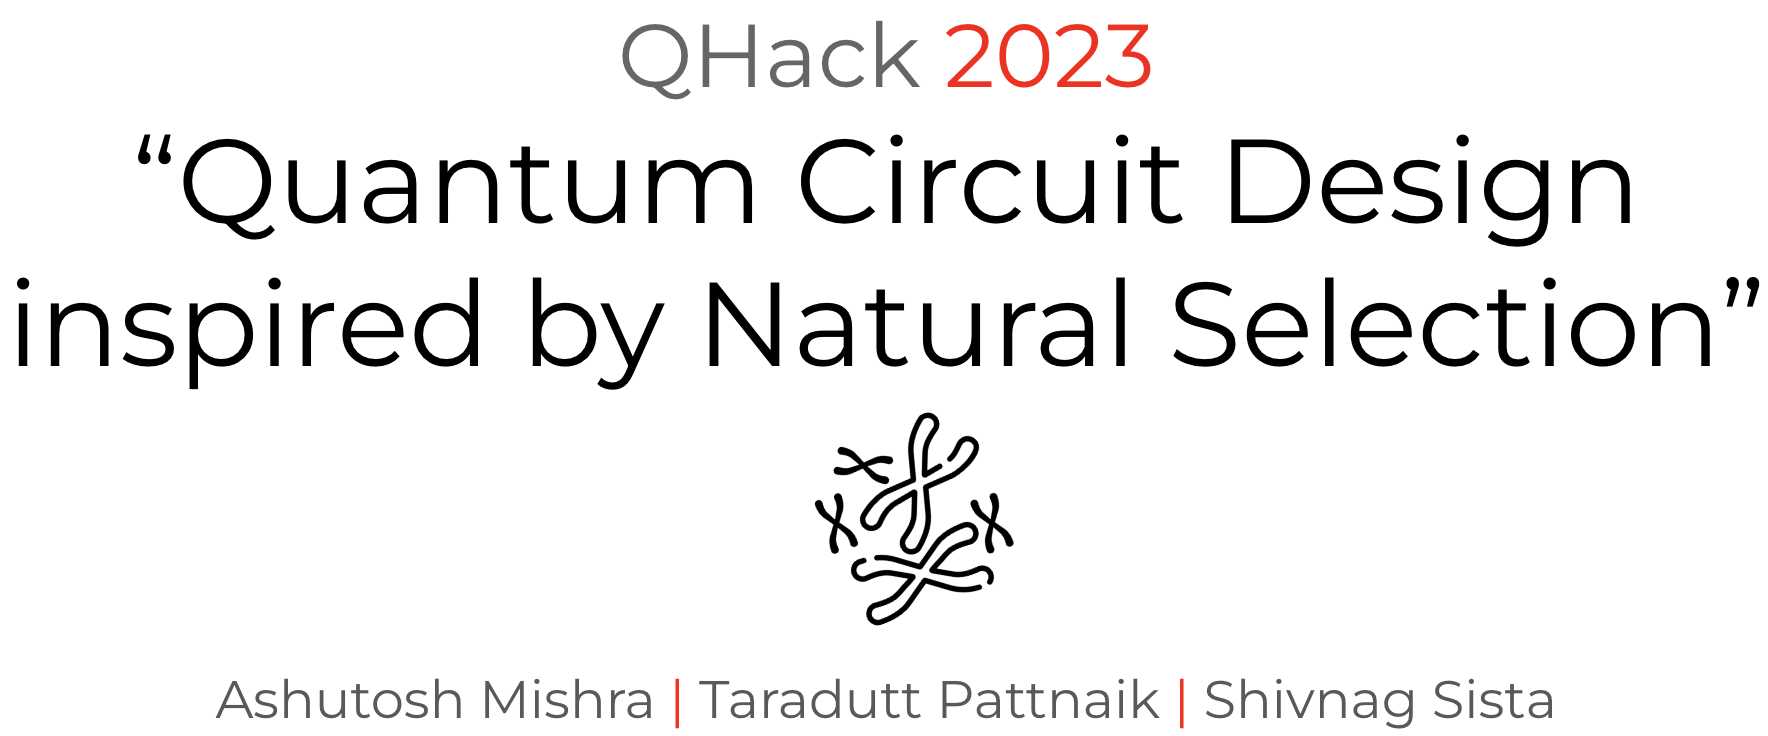

### Motivation

Several applications in quantum computing, quantum information and quantum communication require the preparation of entangled quantum states such as the Bell state, the W state or the GHZ (Greenberger-Horne-Zeilinger) state. One can prepare these states by starting with some initial quantum state and applying **quantum gates** on this state until the target state is reached. This sequence of quantum gates that transform a given initial state to some final state is referred to as a quantum circuit.

Constructing quantum circuits which prepare the required state is often a non-trivial task. Traditionally, the circuits were designed by hand, using a combination of trial and error and accumulated experience to identify design patterns and reusable units from previously made circuits. This process is often tedious very hard to do for all but the simplest of circuits. Furthermore, such a manually constructed circuit is not guaranteed to be the most efficient circuit (i.e. of the lowest circuit depth) which achieves the task.

This is where classical optimization algorithms enter the picture. One may use these algorithms to search the space of possible circuits (subject to some constraints) and identify the circuit which most efficiently produces the required quantum state. There are several approaches to performing such optimization. Of these, the approach we used in this project is **genetic algorithms**.

This goes into the class of Hybrid quantum classical algorithms for quantum circuit design, where there is a quantum circuit to be evaluated by a quantum computer and a classical computer would handle the optimization part.

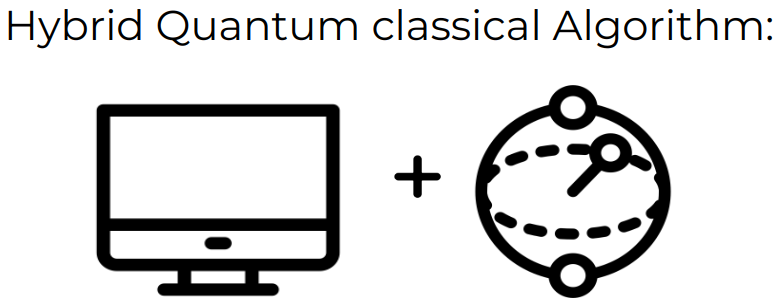

### Overview of Genetic Algorithms

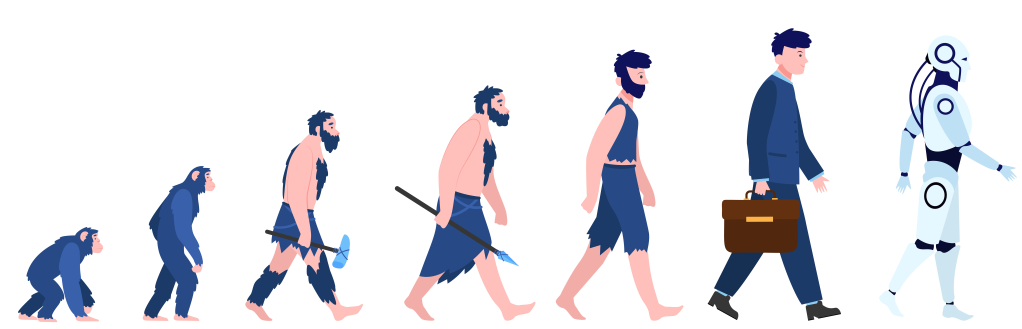
<font size="1"><a href="http://www.freepik.com">*Designed by pch.vector / Freepik</a></font>


Genetic algorithms are a class of optimization algorithms that are named so because they draw inspiration from core concepts of genetics and evolutionary biology. Consider this highly simplified description of the typical process of evolution of a species: The most fit individuals of the population mate with each other to produce the next generation of individuals. This process involves combining the DNA of both parents to form the DNA of the offspring. However, in addition to this recombination, there are random mutations which take place. Mutations that are favorable to the survival of offspring get passed on to latter generations. In this way, subsequent generations end up having more favorable traits (i.e. they are "fitter") compared to previous generations. To summarize, the ingredients of evolution are:
1. Reproduction 
2. Genetic crossover
3. Random mutations
4. Natural selection
  
Genetic algorithms follow the same structure. Given a problem:
1.  We start with a population of candidate solutions to the problem, where individual members of the population are often encoded as some array of values which is often referred to as the **genome**, called so because it plays the same role here as its biological namesake. 
2. We define a **fitness function** to determine the quality (or "fitness") of the solution. Then, we select the fittest members of the population to create the next generation. This is the **selection** step of the algorithm.
3. To create "offspring" solutions from "parent" solutions, we perform a **crossover**. That is, we splice the strings representing the genomes of the parents and recombine them. This crossover is supposed to emulate the genetic recombination that takes place during sexual reproduction.
4. After the crossover, the genomes are modified at random locations to model **mutation**.    
5. This process is then repeated over several generations until the fitness of the individuals converges to some value (which hopefully maximizes the fitness function).

Before we move on to the specifics of the problem and our approach to solving it, it is worth mentioning that organisms can reproduce asexually as well, which would mean a process with all the steps above **except** for the crossover step. Indeed, genetic algorithms can be designed without the crossover step and this has advantages in some situations. However, in most cases, crossover plays an important role in ensuring effective optimization and our approach makes use of the crossover step.




### Problem Setup

The initial and final quantum states are specified in advance and our task is to determine a quantum circuit(s) which performs the required transformation from the initial state to the final state. We want our quantum circuit to have as low a circuit depth as possible. 

#### Genetic Algorithm

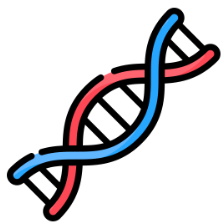

Here we design quantum circuits using genetic algorithms. Genetic algorithms are a class of evolutionary algorithms that are inspired from the process of natural selection and are used for optimization and search problems.

In genetic algorithm, a population of potential solutions is iteratively evolved through the application of selection, crossover, and mutation operators. The process mimics the principles of natural selection and genetics, where the fittest individuals (i.e., those with the best fitness value) are selected for reproduction, and their genetic material is combined to generate offspring. Over time, the population evolves towards a better solution, and the algorithm terminates when a stopping criterion is met.

In the following code we use genetic algorithm for quantum circuit design. It was shown in recent papers [[1](https://arxiv.org/abs/2302.11141), [2](https://arxiv.org/abs/2302.01303)] that such a method can be used to produce that use much less gates and circuit depth to generate the same state. Also since the current quantum devices are noisy, having less circuit depth helps to reduce the total error in the preparation of state.

[1] Creevey, Floyd M., Charles D. Hill, and Lloyd CL Hollenberg. "GASP--A Genetic Algorithm for State Preparation." arXiv preprint arXiv:2302.11141 (2023).

[2] Sünkel, Leo, et al. "GA4QCO: Genetic Algorithm for Quantum Circuit Optimization." arXiv preprint arXiv:2302.01303 (2023).

### Problem solution

For implementing the genetic algorithm, we begin by creating a large population of candidate solutions to the problem at hand, each solution being characterized by a set of parameters that we call its **genome**. Here we refer to each individual **circuit** as an **individual** of the population and the **genes** of an individual refer to the **gates** of the circuit. A collection of these circuits is refered to as the **population**.

In [2]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

import random
import copy

from helper_functions import *

import warnings
warnings.filterwarnings("ignore")

We start with defining the quantum device, the number of qubits on the chip, and the basis set of gates. To be consistent with [[1](https://arxiv.org/abs/2302.11141)] **we define the single qubit rotation gate set and the CNOT gate as the basis gates in our circuit.**

In [3]:
MAX_GATES = 10
MAX_ITER = 15

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

basis_gates = [qml.RX, qml.RY, qml.RZ, qml.CNOT]
basis_gates2 = [qml.RX, qml.RY, qml.RZ]

psi_target = np.array([1, 0, 0, 0, 0, 0, 0, 0]) # |00> state


### 1. Generating a random circuit

To generate an initial population of individuals, we randomly select gates (with random parameters) from the basis gates set. 

In [4]:
def select_random_gate(basis_gates):
    """
    Returns one randomly selected gate from the list of `basis_gates`.
    The input parameters of the gate is also randomly choosen.

    Args:
        basis_gates (List[qml.operation.Operation]): _description_

    Returns:
        qml.operation.Operation: Random gate chosen from the basis set
    """
    gate = random.sample(basis_gates, 1)[0]
    if gate == qml.CNOT:
        return gate(wires=random.sample(range(n_qubits), 2))
    else:
        return gate(2*np.pi*random.random(), wires=random.sample(range(n_qubits),1))

def generate_random_circuit(n_gates):
    """
    Generates a random circuit with `n_gates` number of gates.

    Args:
        n_gates (int): Number of gates in the circuit

    Returns:
        qml.operation.Operation: Randomly generated circuit.
    """
    gates_list = []
    for i in range(n_gates):
        gates_list.append(select_random_gate(basis_gates))
    return gates_list

@qml.qnode(dev)
def circuit_from_list(gates_list):
    """
    Construct a quantum circuit from a list of gates.
    And returns the state of the qubits at the end of the circuit.

    Args:
        gates_list (List[qml.operation.Operation]): List of gates.

    Returns:
        qml.state: State of the qubits at the end of the circuit.
    """
    for gate in gates_list:
        qml.apply(gate)
    return qml.state()

For example a random circuit with 5 gates would be something like - 

(<Figure size 432x288 with 1 Axes>, <Axes:>)

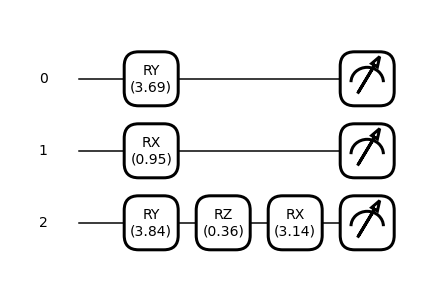

In [5]:
qml.draw_mpl(circuit_from_list, decimals=2)(generate_random_circuit(5))

### 2. Assess the fitness of the population

Next we assess the fitness of the population. We check whether any of the generated individuals fulfill the criteria of the require target state. The fitness of an individual is calculated as the inner product of the target state with the state obtained from the circuit.
$$ F =  |\langle \psi_{Target} |  U_{Circuit}| 0   \rangle|^2 $$ 

In [6]:
def compute_fitness(input, psi_target):
    """
    Compute the fitness of all individuals in the population.
    The fitness is calculated as the inner product of the state generated from an individual
    and the target state.

    Args:
        input (List[List[qml.operation.Operation]]): List of all circuits in the population
        psi_target (np.ndarray): Target state

    Returns:
        List: List of fitness of all individuals in the population
    """
    individuals = copy.deepcopy(input) # input is a list of individuals
    fitness_arr = []
    for i in individuals:
        fitness = inner_product(psi_target, circuit_from_list(i))
        fitness_arr.append(fitness)
    return fitness_arr

### 3. Offsprings - Crossover and Mutation

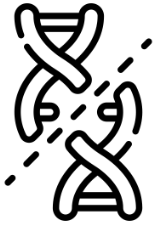

Next, if we haven't found our solution yet, we introduce variability into our population by crossover and mutation. Similar to natural evolution, where the a population with more genetic diversity and variability is fitter, we incorporate that with the genetic algorithm as well. 

Crossover between two individuals is the process in which the offsprings of two individuals carry part of their genes from one parent and others from other parent. We implement a single point cross over which means that one half of the genes are from one parent and other half from the other parent. To be more specific, we build new circuits by merging half of one circuit with the other half of another circuit. Here instead of considering all nC2 possibilities, we double the circuit during crossover. 

Mutation is the process in which some of the genes of an individual are changed with some probability. Here we modify the gates in the circuit with some probability `p`. 

Crossover and mutation, like natural evolution, brings variability in the circuit and helps to search the parameter space of the problem. Additionally, Mutation and crossover add randomization to the circuit and make sure that the solutions are not stuck in a local minima.  


In [7]:
def population_crossover(input):
    """
    Perform crossover for the population.
    Here we select two individuals of the population and do a crossover to create a 
    new generation of individuals.
    This can should generate a population of nC2 individuals,
    but we consider a multiplicity is 2, ie, the population doubles after crossover.
    Since we also generate variability using mutation later we dont need to consider
    all possible combination.

    Args:
        input (List[List[qml.operation.Operation]]): List of all circuits in the population.

    Returns:
        List[List[qml.operation.Operation]]: New generation of individuals
    """
    individuals = copy.deepcopy(input) # input is the list of all individuals
    new_individuals = []
    for i in range(len(individuals)-1):
        temp_ind = crossover(individuals[i], individuals[i+1])
        new_individuals.append(temp_ind[0])
        new_individuals.append(temp_ind[1])

    temp_ind = crossover(individuals[-1], individuals[0])
    new_individuals.append(temp_ind[0])
    new_individuals.append(temp_ind[1])
    
    return new_individuals


def crossover(individual1, individual2):
    """
    Perform crossover for two individuals to create two new individuals.
    Here we add half of one circuit to second-half of other circuit to create new circuit. 

    Args:
        individual1 (List[qml.operation.Operation]): Individual 1
        individual2 (List[qml.operation.Operation]): Individual 2

    Returns:
        List[qml.operation.Operation], List[qml.operation.Operation]: Two new individuals
    """
    cutoff = int(np.floor(len(individual1)/2))
    new_ind1 = individual1[0:cutoff] +  individual2[cutoff:]
    new_ind2 = individual2[0:cutoff] + individual1[cutoff:]
    return new_ind1, new_ind2

def population_mutation(input, p=0.05):
    """
    Mutate the input population with some probability `p` to introduce variablitiy.

    Args:
        input (List[List[qml.operation.Operation]]): List of all circuits in the population
        p (float, optional): probabitlity of mutation. Defaults to 0.05.

    Returns:
        List[List[qml.operation.Operation]]: Muatated population
    """
    individuals_list = copy.deepcopy(input) # input is the list of all individuals
    new_individuals = []
    for i in individuals_list:
        new_individuals.append(mutation(i, p=p))
    return new_individuals


def mutation(individual, p):
    """
    Mutate the gates of one individual with probability p.

    Args:
        individual (List[qml.operation.Operation]): One individual circuit
        p (float): probability of mutation

    Returns:
        List[qml.operation.Operation]: Mutated individual
    """
    random_arr = np.random.rand(len(individual)) - p
    for i in range(len(individual)):
        if random_arr[i] < 0:
            individual = mutate(individual, i)
    return individual

def mutate(individual, pos):
    """
    Mutate the gate at position `pos`.
    For CNOT gate we flip the control and the target qubit.
    For Rotation gate we replace it with a random rotation gate.

    Args:
        individual (List[qml.operation.Operation]): One individual circuit
        pos (int): position of gate to be mutated

    Returns:
        List[qml.operation.Operation]: Individual mutated at position `pos`
    """
    if individual[pos].name == "CNOT":
        individual[pos] = qml.CNOT(wires=[individual[pos].wires[1], individual[pos].wires[0]])
    else:
        individual[pos] = select_random_gate(basis_gates2)
    return individual

An example of crossover would be - (the first two represent parent individuals and the last two represent offsprings)

(<Figure size 432x288 with 1 Axes>, <Axes:>)

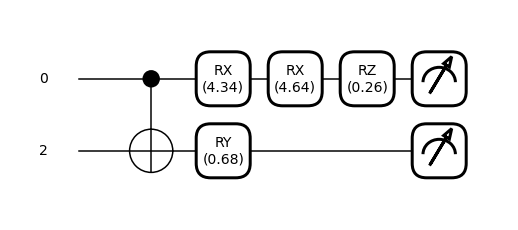

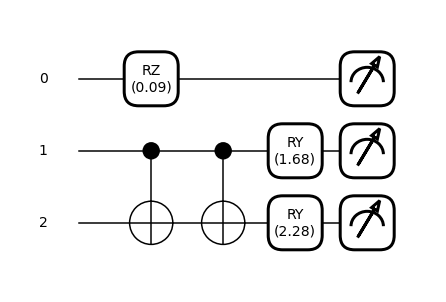

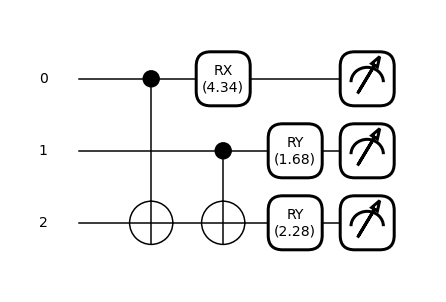

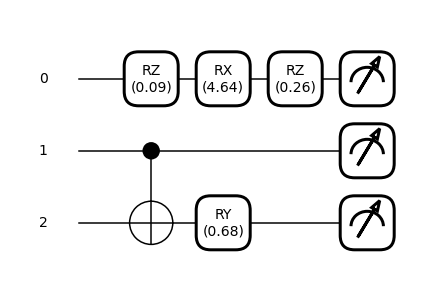

In [8]:
individual1 = generate_random_circuit(5)
individual2 = generate_random_circuit(5)

qml.draw_mpl(circuit_from_list, decimals=2)(individual1)
qml.draw_mpl(circuit_from_list, decimals=2)(individual2)

crossed_individual1, crossed_individual2 = crossover(individual1, individual2)

qml.draw_mpl(circuit_from_list, decimals=2)(crossed_individual1)
qml.draw_mpl(circuit_from_list, decimals=2)(crossed_individual2)

### 4. Optimizing the individuals

Next, we optimize the new individuals created to check for what parameters (angles of the rotation gates) we get the maximum fitness of the population. This optimization is done using the Adam optimizer. To optimize the circuits we deconstruct the circuits to find their parameters and then define a cost function as (1 - Fitness function).

Later we sort the population by their fitness and choose the top 50% individuals for the next generation.

In [9]:
def update_circuit(individual, params, positions):
    """
    Create a new individual using the updated parameters.

    Args:
        individual (List[qml.operation.Operation]): Input individual
        params (List[float]): New parameters of the circuit
        positions (List[int]): specifies what gate is at what position.
                                0  ->  CNOT
                                1  ->  RX
                                2  ->  RY
                                3  ->  RZ

    Returns:
        List[qml.operation.Operation]: Updated individual
    """
    updated_individual = []
    for i in range(len(params)):
        if positions[i] == 0: #CNOT
            updated_individual.append(qml.CNOT(wires=individual[i].wires))
        elif positions[i] == 1: #RX
            updated_individual.append(qml.RX(params[i], wires=individual[i].wires))
        elif positions[i] == 2: #RY
            updated_individual.append(qml.RY(params[i], wires=individual[i].wires))
        elif positions[i] == 3: #RZ
            updated_individual.append(qml.RZ(params[i], wires=individual[i].wires))
    return updated_individual

def optimize_circuit(individual, psi_target):
    """
    Optimize one individual to find the best fitness of the circuit.
    To do this, we need to deconstruct the circuit to find the parameters.
    Then we define a cost function (which is 1 - fitness) for optimization
    and then use an Adam optimizer to optimize the circuit.

    We select the top 50% of the optimized population for next step.


    Args:
        individual (List[qml.operation.Operation]): Individual
        psi_target (np.ndarray): Target state for calculating fitness

    Returns:
        List[qml.operation.Operation]: Optimized individual
    """

    # collect parameters from circuit
    params = [0]*len(individual)
    positions = [0]*len(individual)
    for i in range(len(individual)):
        if individual[i].name != "CNOT":
            params[i] = individual[i].parameters[0]
            if individual[i].name == "RX":
                positions[i] = 1
            elif individual[i].name == "RY":
                positions[i] = 2
            elif individual[i].name == "RZ":
                positions[i] = 3
    
    params = np.array(params, requires_grad=True)

    # Reconstruct the circuit from the parameters
    @qml.qnode(dev)
    def circuit(params):
        for i in range(len(params)):
            if positions[i] == 0: #CNOT
                qml.CNOT(wires=individual[i].wires)
            elif positions[i] == 1: #RX
                qml.RX(params[i], wires=individual[i].wires)
            elif positions[i] == 2: #RY
                qml.RY(params[i], wires=individual[i].wires)
            elif positions[i] == 3: #RZ
                qml.RZ(params[i], wires=individual[i].wires)

        return qml.state()

    # Define the cost function
    def cost(params):
        state = circuit(params)
        fitness = inner_product(psi_target, state)
        return 1 - fitness


    # Optimization
    opt = qml.AdamOptimizer(0.5)
    for i in range(100):
        params, prev_cost = opt.step_and_cost(cost, params)
        # if i%99==0:
        #     print(f'Step: {i} ,Cost: {prev_cost}') 
    
    optimized_individual = update_circuit(individual, params, positions)

    return optimized_individual


def population_optimization(individuals, psi_target):
    """
    Optimization of the whole population.

    Args:
        individuals (List[List[qml.operation.Operation]]): Population
        psi_target (np.ndarray): Target state

    Returns:
        List[List[qml.operation.Operation]]: optimized population
    """
    optimized_individuals = []
    individuals_copy = copy.deepcopy(individuals)
    for i in individuals_copy:
        optimized_individuals.append(optimize_circuit(i, psi_target))
    return optimized_individuals


### 5. Running the algorithm

Finally we merge all the above steps to form the genetic algorithm. Here we iterate the above steps with a given number of gates in the circuit. If we reach `MAX_ITER` number of steps and we don't have a solution, then we increase a gate in the circuit and run the evolution again. 

In [10]:
def add_gate(individual):
    """
    Add a random gate to an individual

    Args:
        individual (List[qml.operation.Operation]): Individual

    Returns:
        List[qml.operation.Operation]: updated individual
    """
    new_gate = generate_random_circuit(1)
    return individual + new_gate

def population_add_gate(individuals):
    """
    Add a random gate to every circuit in the population

    Args:
        individuals (List[List[qml.operation.Operation]]): Population of all individuals

    Returns:
        List[List[qml.operation.Operation]]: Updated population
    """
    new_individuals = [add_gate(i) for i in individuals]
    return new_individuals

In [11]:
def generate_circuits(psi_target, n=20, n_gates=2, p=0.2, fitness_tol=0.95):
    """
    Quantum circuits constructed by using genetic algorithm.

    Args:
        psi_target (np.ndarray): Target state to be achieved
        n (int, optional): Number of individuals in each generation. Defaults to 20.
        n_gates (int, optional): Number of gates initially in the circuit. Defaults to 9.
        p (float, optional): Probability of mutation. Defaults to 0.2
        fitness_tol (float, optional): fitness tolerance for selection. Defaults to 0.95. 
    """

    finished_flag = False
    n_gates_intial = copy.deepcopy(n_gates)

    individuals = [] # List of randomly generated initial individuals
    for i in range(n):
        # print(f"Generating circuit {i}")
        individuals.append(generate_random_circuit(n_gates))

    final_result = []

    print("Starting Genetic algorithm")
    while n_gates < MAX_GATES:
        # print(f"Starting with gates {n_gates}")

        if n_gates != n_gates_intial:
            individuals = population_add_gate(individuals)

        n_iter = 1

        while n_iter < MAX_ITER:

            # print(f"Iteration {n_iter} starting ...")


            fitnesses = compute_fitness(individuals, psi_target)
            # TODO - Assess fitness and check for termination
            for i, fit in enumerate(fitnesses):
                if fit >= fitness_tol:
                    finished_flag = True
                    final_result.append(individuals[i])
                    print("Found solution!!!")
                    print(f"Fitness = {fit}")

            if finished_flag:
                break

            # Crossover
            crossover_individuals = population_crossover(individuals)

            # Mutation of population
            mutated_individuals = population_mutation(crossover_individuals, p=p)

            # Angle optimization
            # print("Starting optimization")
            optimized_individuals = population_optimization(mutated_individuals, psi_target)
            # print("Finished optimization")


            # compute fitness and selection
            fitnesses_before_selection = compute_fitness(optimized_individuals, psi_target)

            sorted_indices = np.argsort(fitnesses_before_selection)

            # updating individuals
            individuals = [optimized_individuals[i] for i in sorted_indices[-n:]] 

            n_iter += 1

        
        if finished_flag:
            break

        # increasing the number of gates after MAX_ITER  
        n_gates += 1
        # print(f"Increasing number of gates to {n_gates}")

    return final_result


### 6. Process results

In [12]:
def process_results(final_result):
    if len(final_result) > 1:
        print(f"Found {len(final_result)} circuits!")
    else:
        print(f"Found {len(final_result)} circuit!")

    for i in range(len(final_result)):
        print(qml.draw(circuit_from_list)(final_result[i]))
        qml.draw_mpl(circuit_from_list, decimals=2)(final_result[i])

# Results

## 1. T-gate Magic state

We start with some of the simplest circuits, involving only one qubit and single qubit rotation gates. We try to find a circuit that can produce a T-type magic state. Magic states were introduced by Bravyi and Kitaev [[3](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.71.022316)] and are helpful in quantum error correction.

The T-gate magic state is given by $|T_0\rangle = cos(\beta)|0\rangle + e^{i\frac{\pi}{4}} sin(\beta) |1\rangle$

**Choosing $\beta = \frac{\pi}{3}$**


Here we start the circuits with only one gate initially and let the algorithm figure out circuits that can produce the T-gate magic state. 


[3] Bravyi, Sergey, and Alexei Kitaev. "Universal quantum computation with ideal Clifford gates and noisy ancillas." Physical Review A 71.2 (2005): 022316.

In [12]:
MAX_GATES = 10
MAX_ITER = 15

n_qubits = 1
dev = qml.device("default.qubit", wires=n_qubits)

beta = np.pi/3
psi_target = np.array([np.cos(beta) , np.exp(1j*np.pi/4)*np.sin(beta)]) # Magic state T_0
psi_target = psi_target/np.linalg.norm(psi_target)

basis_gates = [qml.RX, qml.RY, qml.RZ] # No CNOT in the basis gates as we are only using 1 qubit
basis_gates2 = [qml.RX, qml.RY, qml.RZ]

# reinitializing dev

@qml.qnode(dev)
def circuit_from_list(gates_list):
    """
    Construct a quantum circuit from a list of gates.
    And returns the state of the qubits at the end of the circuit.

    Args:
        gates_list (List[qml.operation.Operation]): List of gates.

    Returns:
        qml.state: State of the qubits at the end of the circuit.
    """
    for gate in gates_list:
        qml.apply(gate)
    return qml.state()

In [13]:
psi_target

tensor([0.5       +0.j        , 0.61237244+0.61237244j], requires_grad=True)

In [14]:
final_result = generate_circuits(
                    psi_target=psi_target,
                    n=10,
                    n_gates=1,
                    fitness_tol=0.99
)

Starting Genetic algorithm
Increasing number of gates to 2
Found solution!!!
Fitness = 0.9999678278698916
Found solution!!!
Fitness = 0.9999828092704415
Found solution!!!
Fitness = 0.9999828092704415
Found solution!!!
Fitness = 0.999993620650623
Found solution!!!
Fitness = 0.9999959245713013
Found solution!!!
Fitness = 0.9999998066033962
Found solution!!!
Fitness = 0.9999999689769852


Found 7 circuits!
0: ──RX(-0.66)──RY(2.27)─┤  State
0: ──RY(4.19)──RZ(3.94)─┤  State
0: ──RY(4.19)──RZ(3.94)─┤  State
0: ──RY(2.49)──RX(7.17)─┤  State
0: ──RY(0.66)──RX(4.03)─┤  State
0: ──RY(0.66)──RX(4.03)─┤  State
0: ──RX(3.80)──RY(5.40)─┤  State


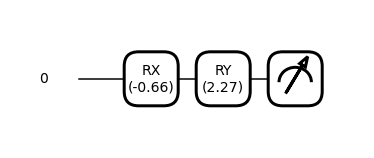

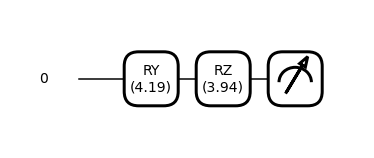

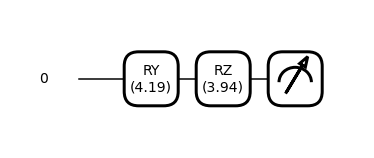

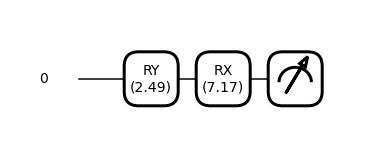

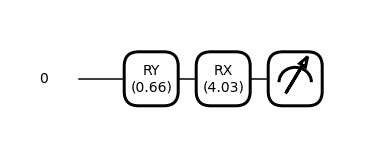

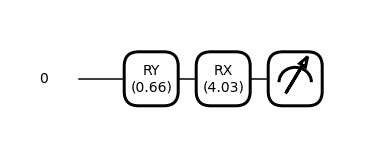

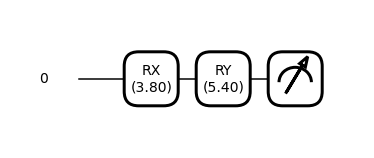

In [15]:
process_results(final_result)

In [16]:
qml_to_qasm(final_result[-1])

rx(3.8) q[0];
ry(5.4) q[0];


In [17]:
compute_fitness(final_result, psi_target)

[tensor(0.99996783, requires_grad=True),
 tensor(0.99998281, requires_grad=True),
 tensor(0.99998281, requires_grad=True),
 tensor(0.99999362, requires_grad=True),
 tensor(0.99999592, requires_grad=True),
 tensor(0.99999981, requires_grad=True),
 tensor(0.99999997, requires_grad=True)]

## 2. Bell state $|\Phi^+\rangle$

Increasing the complexity a bit, we move to two qubits, and try to produce entangled states. An very important example of the two qubit entangled state are the Bell states or the EPR pairs. Bell states are a set of maximally entangled states and are useful for superdense coding and quantum teleportation.

The Bell state $|\Phi^+\rangle$ is given by - 
$$ |\Phi^+\rangle  = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle) $$

In [18]:
MAX_GATES = 10
MAX_ITER = 15

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

psi_target = np.array([1, 0, 0, 1])/np.sqrt(2) # |00> + |11> - bell state
psi_target = psi_target/np.linalg.norm(psi_target)

basis_gates = [qml.RX, qml.RY, qml.RZ, qml.CNOT]
basis_gates2 = [qml.RX, qml.RY, qml.RZ]

# reinitializing dev

@qml.qnode(dev)
def circuit_from_list(gates_list):
    """
    Construct a quantum circuit from a list of gates.
    And returns the state of the qubits at the end of the circuit.

    Args:
        gates_list (List[qml.operation.Operation]): List of gates.

    Returns:
        qml.state: State of the qubits at the end of the circuit.
    """
    for gate in gates_list:
        qml.apply(gate)
    return qml.state()

In [19]:
final_result = generate_circuits(
                    psi_target=psi_target,
                    n=10,
                    n_gates=2
)

Starting Genetic algorithm
Found solution!!!
Fitness = 0.9999876204436691


Found 1 circuit!
0: ──RY(7.86)─╭●─┤  State
1: ───────────╰X─┤  State


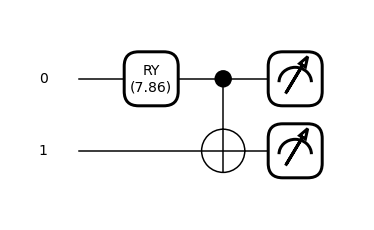

In [20]:
process_results(final_result)

In [21]:
qml_to_qasm(final_result[0])

ry(7.86) q[0];
cx q[0], q[1];


## 3. Bell State $|\Phi^-\rangle$

Next we try to find a circuit to construct the $|\Phi^-\rangle$ state.
It is given by - 
$$ |\Phi^-\rangle  = \frac{1}{\sqrt{2}} (|00\rangle - |11\rangle) $$

In [22]:
MAX_GATES = 10
MAX_ITER = 15

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

psi_target = np.array([1, 0, 0, -1])/np.sqrt(2) # |00> - |11> - bell state

psi_target = psi_target/np.linalg.norm(psi_target)

basis_gates = [qml.RX, qml.RY, qml.RZ, qml.CNOT]
basis_gates2 = [qml.RX, qml.RY, qml.RZ]

@qml.qnode(dev)
def circuit_from_list(gates_list):
    """
    Construct a quantum circuit from a list of gates.
    And returns the state of the qubits at the end of the circuit.

    Args:
        gates_list (List[qml.operation.Operation]): List of gates.

    Returns:
        qml.state: State of the qubits at the end of the circuit.
    """
    for gate in gates_list:
        qml.apply(gate)
    return qml.state()

In [24]:
final_result = generate_circuits(
                    psi_target=psi_target,
                    n=10,
                    n_gates=2
)

Starting Genetic algorithm
Found solution!!!
Fitness = 0.9999999514839019


Found 1 circuit!
0: ───────────╭X─┤  State
1: ──RY(4.71)─╰●─┤  State


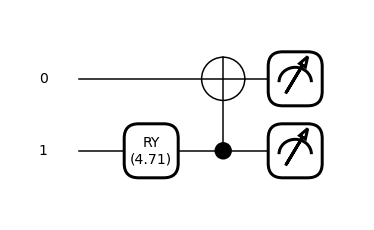

In [25]:
process_results(final_result)

In [26]:
qml_to_qasm(final_result[0])

ry(4.71) q[1];
cx q[1], q[0];


## 4. 3-Qubit GHZ state

A generalization of the Bell states are the **GHZ** states (Greenberger–Horne–Zeilinger states). These are a set of maximally entangled states for higher qubit numbers. We try to design the circuit to produce a 3-Qubit GHZ state:
$$ |GHZ\rangle = \frac{1}{\sqrt{2}}(|000\rangle + |111\rangle) $$

GHZ state can be used to correct 3 Qubit bit flip errors using a 3-Qubit error correcting code.

In [13]:
MAX_GATES = 10
MAX_ITER = 15

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

psi_target = np.array([1, 0, 0, 0, 0, 0, 0, 1])/np.sqrt(2) # |000> + |111> = GHZ state
psi_target = psi_target/np.linalg.norm(psi_target)

basis_gates = [qml.RX, qml.RY, qml.RZ, qml.CNOT]
basis_gates2 = [qml.RX, qml.RY, qml.RZ]

@qml.qnode(dev)
def circuit_from_list(gates_list):
    """
    Construct a quantum circuit from a list of gates.
    And returns the state of the qubits at the end of the circuit.

    Args:
        gates_list (List[qml.operation.Operation]): List of gates.

    Returns:
        qml.state: State of the qubits at the end of the circuit.
    """
    for gate in gates_list:
        qml.apply(gate)
    return qml.state()

In [14]:
final_result = generate_circuits(
                    psi_target=psi_target,
                    n=10,
                    n_gates=3
)

Starting Genetic algorithm


Found 1 circuit!
0: ────────────────────╭X─┤  State
1: ─╭●─╭●───────────╭X─╰●─┤  State
2: ─╰X─╰X──RY(1.57)─╰●────┤  State


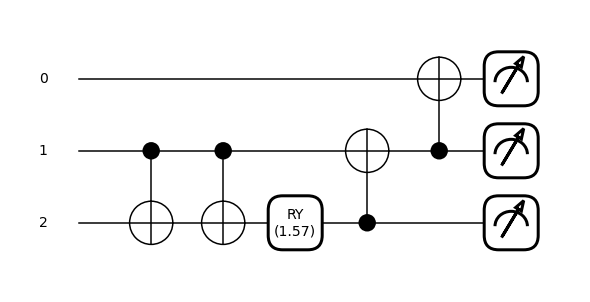

In [29]:
process_results(final_result)

In [30]:
qml_to_qasm(final_result[0])

cx q[1], q[2];
cx q[1], q[2];
ry(1.57) q[2];
cx q[2], q[1];
cx q[1], q[0];


## 5. 3-Qubit W state

As shown in Wolfgang Dür, Guifré Vidal and Ignacio Cirac [[4](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.62.062314)] that there are two inequivalent types of 3-Qubit maximally mixed states - the GHZ state and the W state. 
The W state is given by:
$$ |W\rangle = \frac{1}{\sqrt{3}}(|001\rangle + |010\rangle + |100\rangle) $$

The standard circuit to generate a W state is given by 

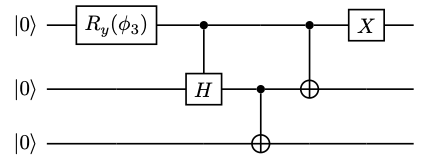

This circuit contains a controlled Hadamard gate. Our circuit only uses single qubit rotation gates and CNOT gates to produce the same state. 

This shows that this algorithm can also be use for quantum circuit compilation and can produce equivalent circuits for many circuits containing controlled unitary gates, which are hard to implement experimentally.


[4] Dür, Wolfgang, Guifre Vidal, and J. Ignacio Cirac. "Three qubits can be entangled in two inequivalent ways." Physical Review A 62.6 (2000): 062314.

In [31]:
MAX_GATES = 13
MAX_ITER = 25

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

psi_target = np.array([0, 1, 1, 0, 1, 0, 0, 0])/np.sqrt(3) # W state
psi_target = psi_target/np.linalg.norm(psi_target)

basis_gates = [qml.RX, qml.RY, qml.RZ, qml.CNOT]
basis_gates2 = [qml.RX, qml.RY, qml.RZ]


@qml.qnode(dev)
def circuit_from_list(gates_list):
    """
    Construct a quantum circuit from a list of gates.
    And returns the state of the qubits at the end of the circuit.

    Args:
        gates_list (List[qml.operation.Operation]): List of gates.

    Returns:
        qml.state: State of the qubits at the end of the circuit.
    """
    for gate in gates_list:
        qml.apply(gate)
    return qml.state()

In [ ]:
final_result = generate_circuits(
                    psi_target=psi_target,
                    n=20,
                    n_gates=9
)

Found 1 circuit!
0: ───────────╭X──RZ(3.15)───RY(2.29)──RY(5.10)─╭●──────────────┤  State
1: ──RY(5.56)─╰●──RY(-4.25)─────────────────────│──╭●──RX(3.14)─┤  State
2: ─────────────────────────────────────────────╰X─╰X───────────┤  State


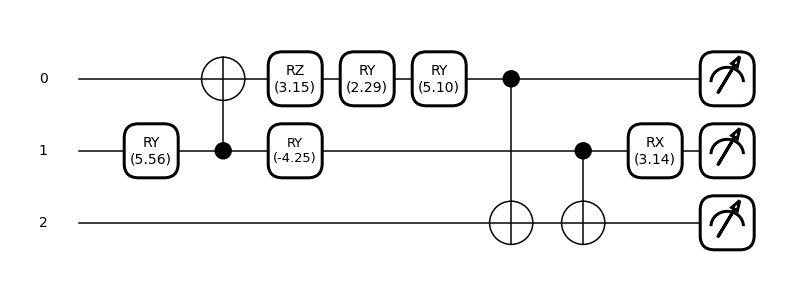

In [37]:
process_results(final_result)

In [35]:
qml_to_qasm(final_result[0])

ry(5.56) q[1];
cx q[1], q[0];
ry(-4.25) q[1];
rz(3.15) q[0];
ry(2.29) q[0];
ry(5.1) q[0];
cx q[0], q[2];
cx q[1], q[2];
rx(3.14) q[1];
